In [43]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import curve_fit
from scipy.integrate import cumulative_trapezoid
from tqdm import tqdm
import random
import math

In [117]:
# Classe do Model de Ising
class IsingModel:
    def __init__( self, L, T, J=1, H=0, Kb=1):
        # parametros do modelo
        self.L = L
        self.T = T
        self.J = J
        self.H = H
        self.Kb = Kb

        # array com os spins
        self.spins = np.ones( (L, L) )

        # arrays para guardar evolução das vari´aveis
        self.energies = []
        self.magnetizations = []

        self.nns = [(-1,0),(1,0),(0,-1),(0,1)]


    def calc_ener_spin( self, i, j ):
        # calcular a energia de um spin
        energy = 0
        s = self.spins[i,j]
        for (di,dj) in self.nns:
            s_n = self.spins[(i+di) % self.L, (j+dj) % self.L]
            energy += self.J * s * s_n 
        if self.H!=0:
            energy += self.h*s
        return energy

    def calc_ener( self ):
        # calcular a energia por spin do sistema
        # e = E / L^2
        total_energy = 0
        for i in range(0, self.L):
            for j in range(0, self.L):
                total_energy += self.calc_ener_spin(i, j)  
        energy = total_energy / (self.L**2)
        return energy

    def calc_energy_local( self, i, j):
        # compute local energy in neighborhood of (i,j) 
        energy_local = 0
        for (di,dj) in self.nns:
            energy_local += self.calc_ener_spin((i+di) % self.L, (j+dj) % self.L)
        return energy_local

    def calc_mag( self ):
        # calcular a magnetiza¸c~ao por spin do sistema
        # m = M / L^2
        total_mag = 0
        for i in range(0, self.L):
            for j in range(0, self.L):
                total_mag += self.spins[i,j]  
        mag = total_mag / (self.L**2)
        return mag

    def update_stats(self, energy, mag):
        self.energies.append(energy)
        self.magnetizations.append(mag)

    def boltzman_factor(self, energy):
        return math.exp(-energy/(self.Kb*self.T))
        
    def iter_monte_carlo( self, n_iter ):
        # iterar com o m´etodo de Metropolis Hastings
        #1.Escolher uma posiçãoo na rede aleatoriamente e trocar o valor do spin nessa posiçãoo, si ← −si
        #2. Calcular a diferen¸ca de energia ∆E entre a configuraçãoo anterior, X e a nova configuraçãoo, X
        #3. Aceitar a nova configuraçãoo caso ∆E < 0 ou e−∆E/kbT > u, sendo u um n´umero aleat´orio gerado a
        #partir de uma distribuiçãoo uniforme, u ∼ U [0, 1), isto ´e X ← X∗. Rejeitar caso contr´ario, mantendo a
        #configuraçãoo original. Aceitar significa alterar o valor do spin da posiçãoo escolhida, e atualizar o valor
        #da energia para a energia do novo sistema
        energy = self.calc_ener()
        mag = self.calc_mag()
        self.update_stats(energy, mag)
        total_energy = energy*(self.L**2)
        total_mag = mag*(self.L**2)
        mag = self.calc_mag()
        for t in tqdm( range(n_iter), desc=f"L={self.L:6d}, T={self.T:8f}" ):
            i,j = random.randint(0, self.L-1), random.randint(0, self.L-1)
            e = self.calc_energy_local(i, j)
            s = self.spins[i,j]
            s_ = -s #flip
            self.spins[i,j] = s_
            e_ = self.calc_energy_local(i, j)
            de = e_-e 
            accept = False
            if de<0:
                accept = True
            else:
                bf = self.boltzman_factor(de)
                if bf > random.random():
                    accept = True

            if not accept:
                self.spins[i,j] = s #revert
                continue
                
            total_energy += de 
            total_mag += 2*s_ 
            energy = total_energy/(self.L**2)
            mag = total_mag/(self.L**2)
            self.update_stats(energy, mag)
                    

    @property
    def energy(self):
        # usa para aceder ao array com as energias
        return np.array(self.energies)

    @property
    def magnetization(self):
        # usa para aceder ao array com as magnetiza¸c~oes
        return np.array(self.magnetizations)

    def t_term_fit(self, N, t_term):
        e0, ef = self.energies[0], self.energies[-1]        
        return ef + (e0 - ef )*np.exp(-N/t_term) 
    
    def fit_t_termalization(self):
        def t_term_fit(N, t_term):
            return self.t_term_fit(N, t_term) 
        energy = self.energy
        xx = np.linspace(0,energy.shape[0], energy.shape[0])
        popt, pcov = curve_fit(t_term_fit, xx, energy)
        return popt[0]

        

In [127]:
def ising_plot_energy(ising, ax=None):
    fig = None
    if ax is None:
        nrows,ncols = 1,1
        fig, axs = plt.subplots(nrows,ncols, figsize=(20,5*nrows))
        ax = axs
    ax.set_title(f'Ising: Mean Energy (L={ising.L}, T={ising.T:f})')
    ax.plot(ising.energy, label='<E>')
    ax.legend()
    if fig is not None:
        plt.show()

def ising_plot_mag(ising, ax=None):
    fig = None
    if ax is None:
        nrows,ncols = 1,1
        fig, axs = plt.subplots(nrows,ncols, figsize=(20,5*nrows))
        ax = axs
    ax.set_title(f'Ising: Mean Magnetization (L={ising.L}, T={ising.T:f})')
    ax.plot(ising.magnetization, label='<M>')
    ax.legend()
    if fig is not None:
        plt.show()

def ising_plot_energy_fit(ising, ax):
    yfit = []
    energy = ising.energy
    xx = np.linspace(0,energy.shape[0], energy.shape[0])
    t_term = ising.fit_t_termalization()
    yfit = ising.t_term_fit(xx, t_term)         
    ax.plot(yfit, color='g', label='fit(<E>)')
    ax.legend()

def ising_plot_t_term(ising, ax):
    t_term = ising.fit_t_termalization()
    ymin, ymax = ax.get_ylim()
    ax.vlines(t_term, ymin=ymin, ymax=ymax, color='r', linestyles='--', lw=1)
    xpad = 4
    ax.text(t_term+xpad, ymin, f't_term={t_term:.4f}', color='r', fontsize=8)

def ising_plot_all(ising):
    nrows,ncols = 1,2
    fig, axs = plt.subplots(nrows,ncols, figsize=(20,5*nrows))
    ising_plot_energy(ising, axs[0])
    ising_plot_energy_fit(ising, axs[0])
    ising_plot_t_term(ising, axs[0])
    ising_plot_mag(ising, axs[1])
    ising_plot_t_term(ising, axs[1])
    plt.show()

    

L=    16, T=2.000000: 100%|████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 27023.41it/s]


t_term: 104.9969767107037


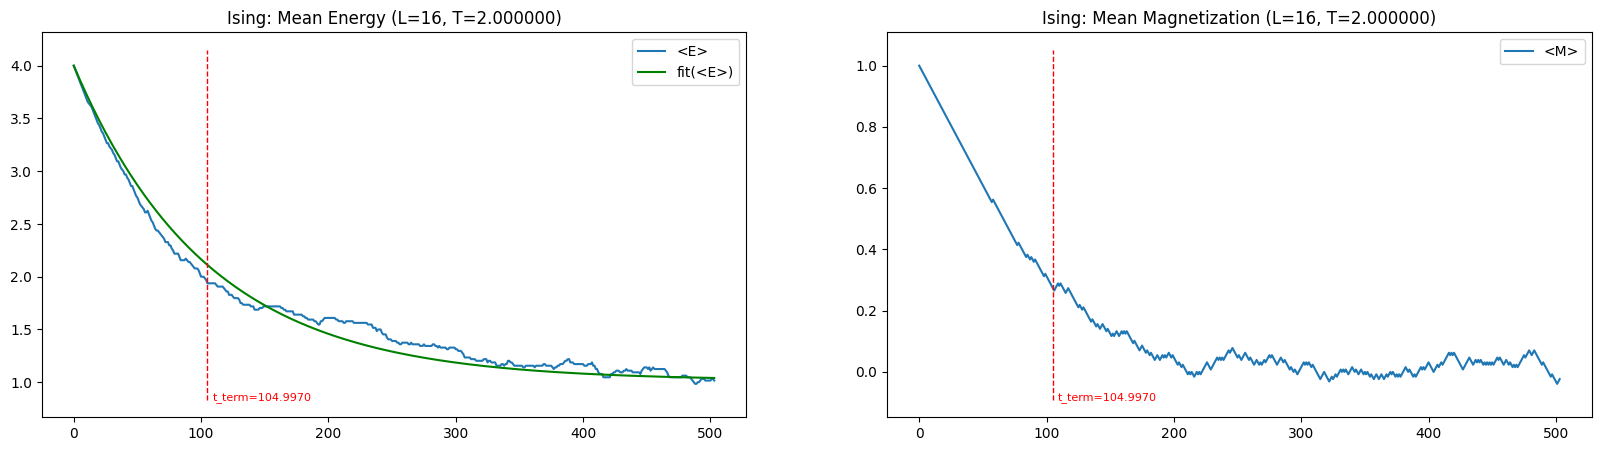

In [128]:
def test_ising(debug=False, plot=True):
    L = 16
    T = 2
    n_iter = 1000
    ising = IsingModel( L, T ) # criar um objecto da classe IsingModel
    ising.iter_monte_carlo( n_iter ) # correr o algoritmo de Metropolis-Hastings
    # aceder aos np.array que cont^em a energia e a magnetiza¸c~ao do sistema a cada itera¸c~ao MC
    energy = ising.energy
    magnetization = ising.magnetization
    t_term = ising.fit_t_termalization()
    print('t_term:', t_term)
    if debug:
        print('energy:', energy)
        print('magnetization:', magnetization)

    ising_plot_all(ising)
    
test_ising(debug=False)

In [129]:
def ising_run_experiments(n_iter = 100000):
    isings = {}
    for L in [16, 32, 64, 128]:
        for T in [1, 2, 3, 4]:
            ising = IsingModel( L, T )
            ising.iter_monte_carlo( n_iter )
            key = (L, T)
            isings[key] = ising
    return isings

def ising_plot_experiments(isings):
    for k, ((L,T),ising) in enumerate(isings.items()):
        ising_plot_all(ising)

isings = ising_run_experiments()


L=   128, T=4.000000: 100%|████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:02<00:00, 34146.88it/s]


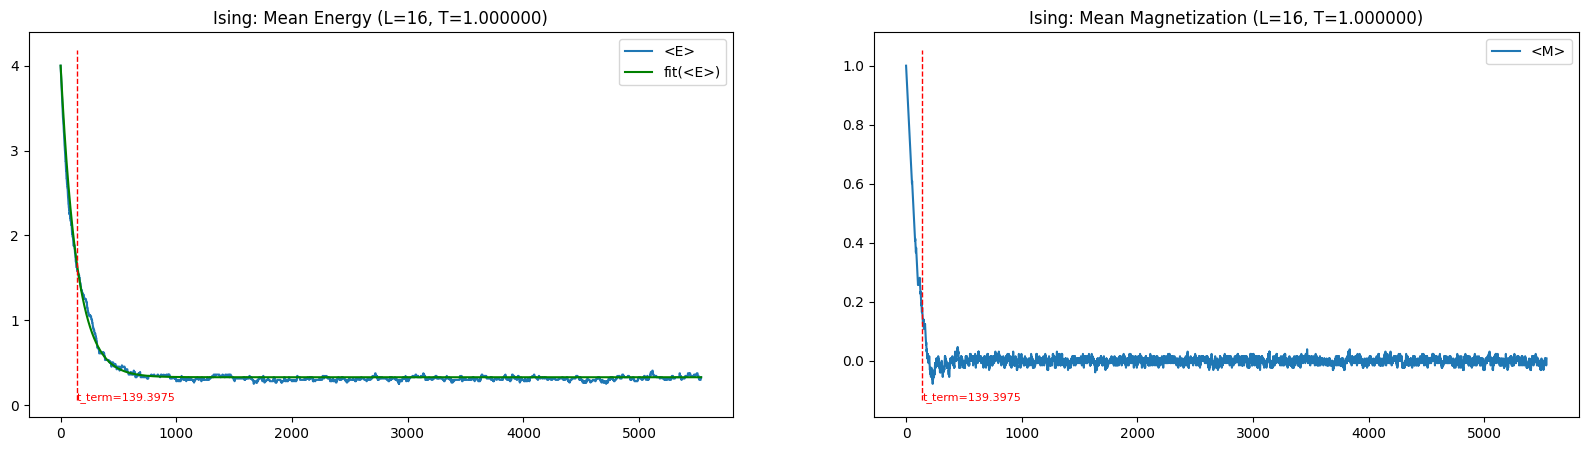

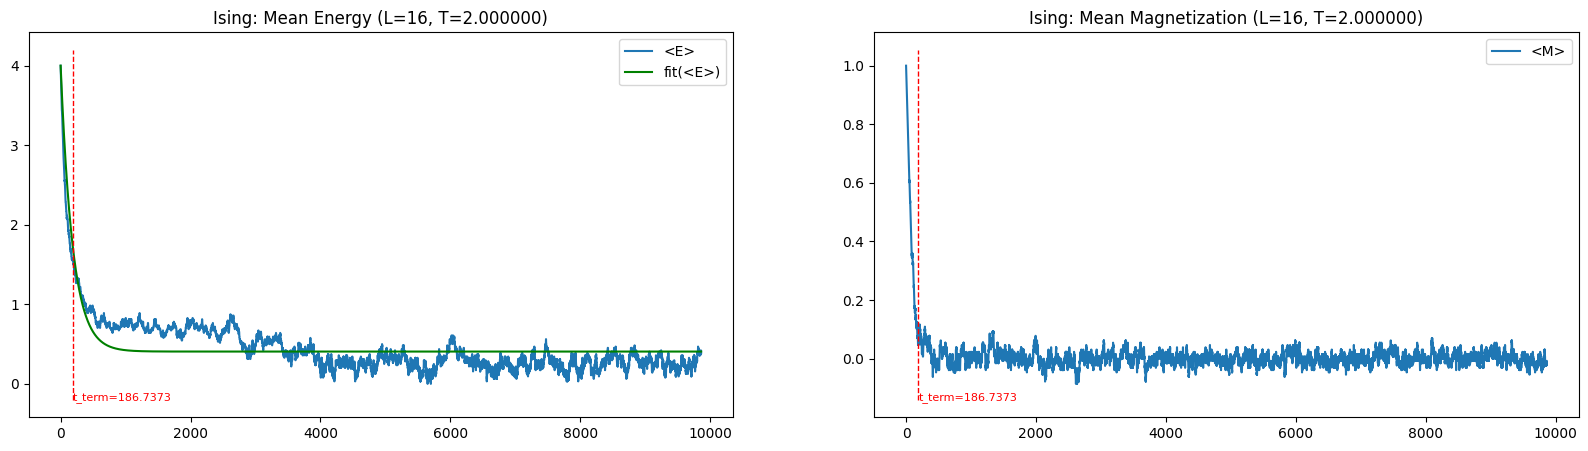

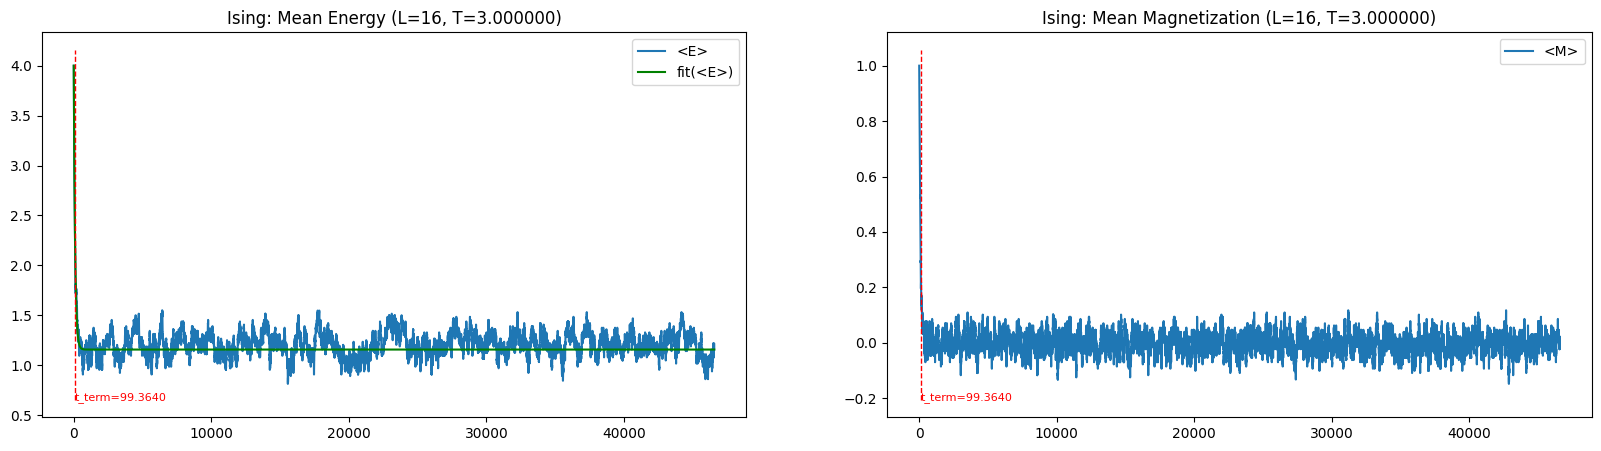

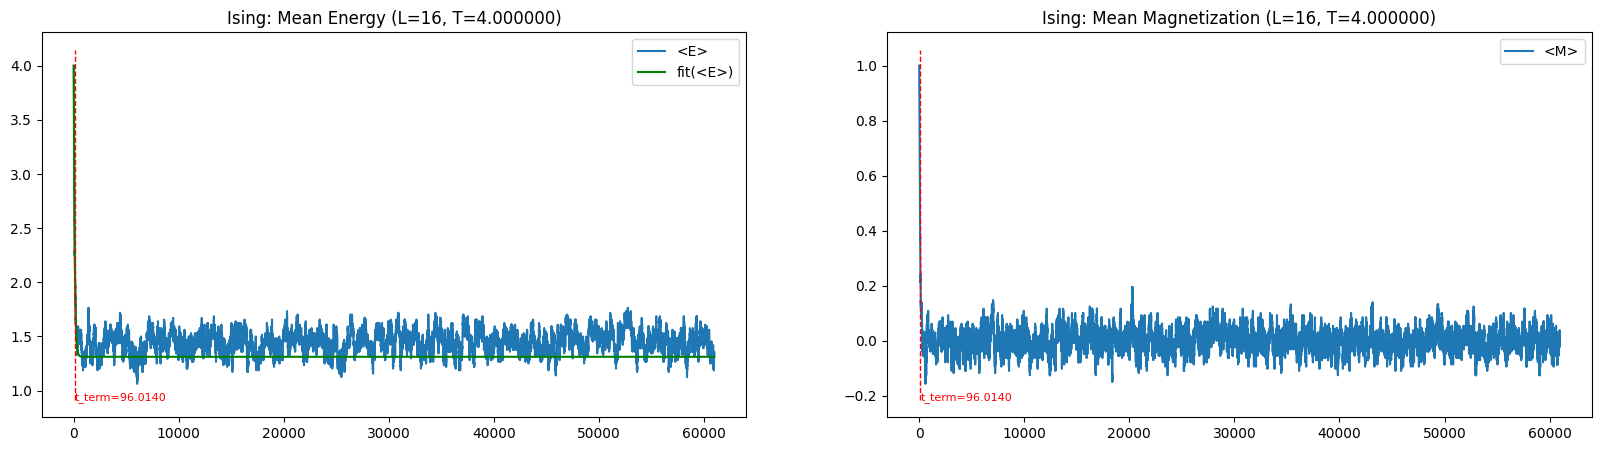

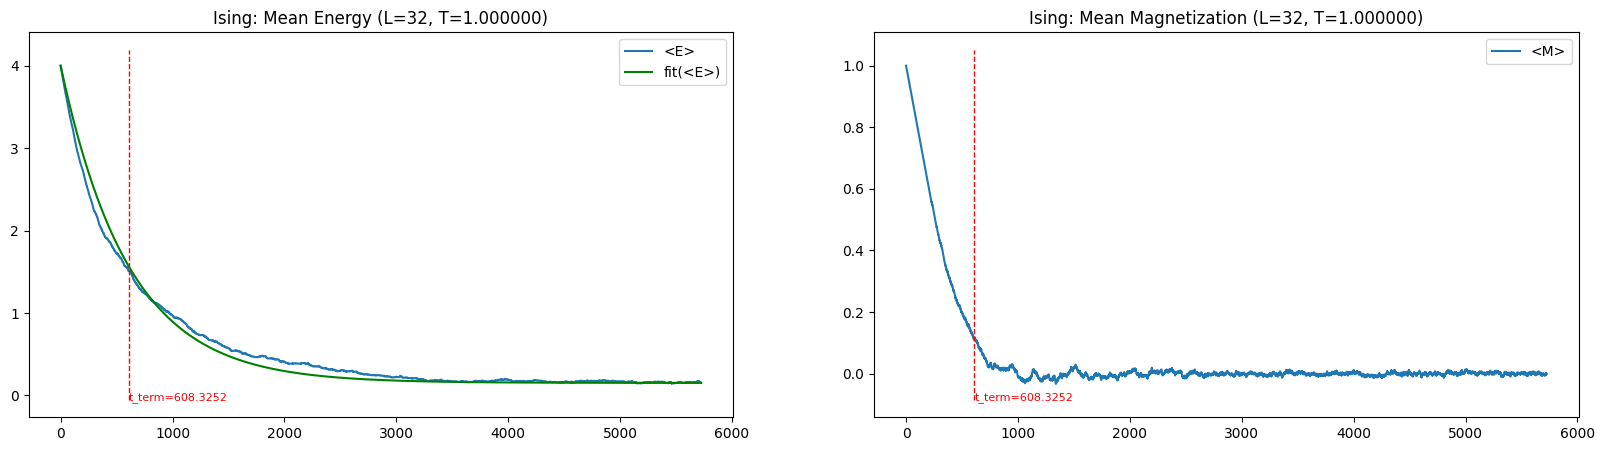

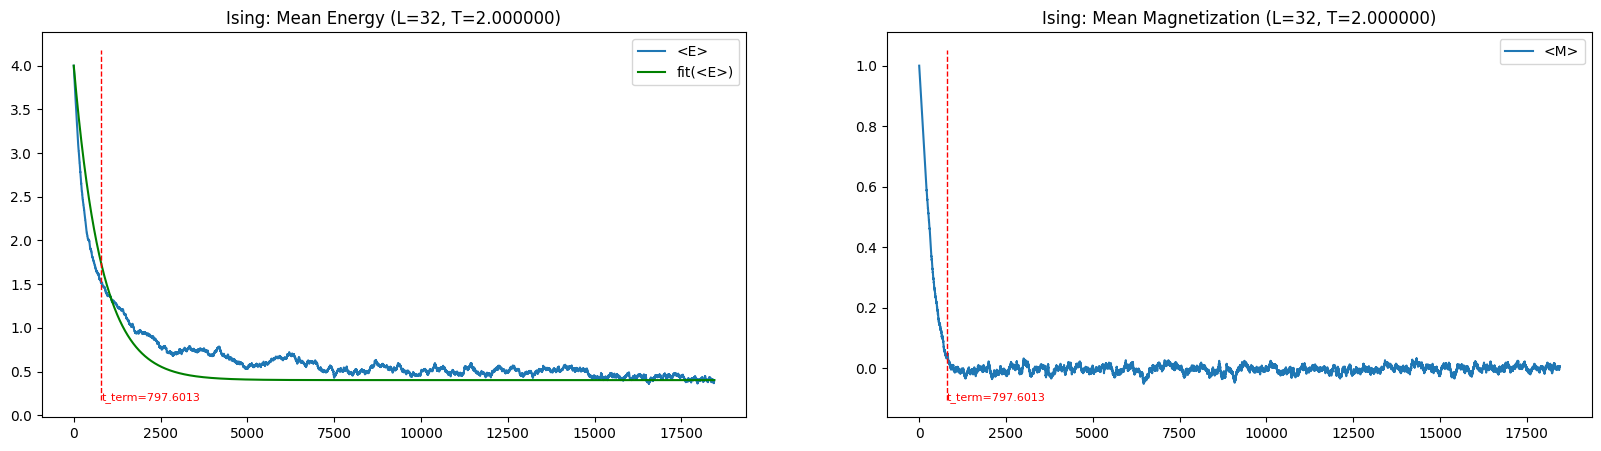

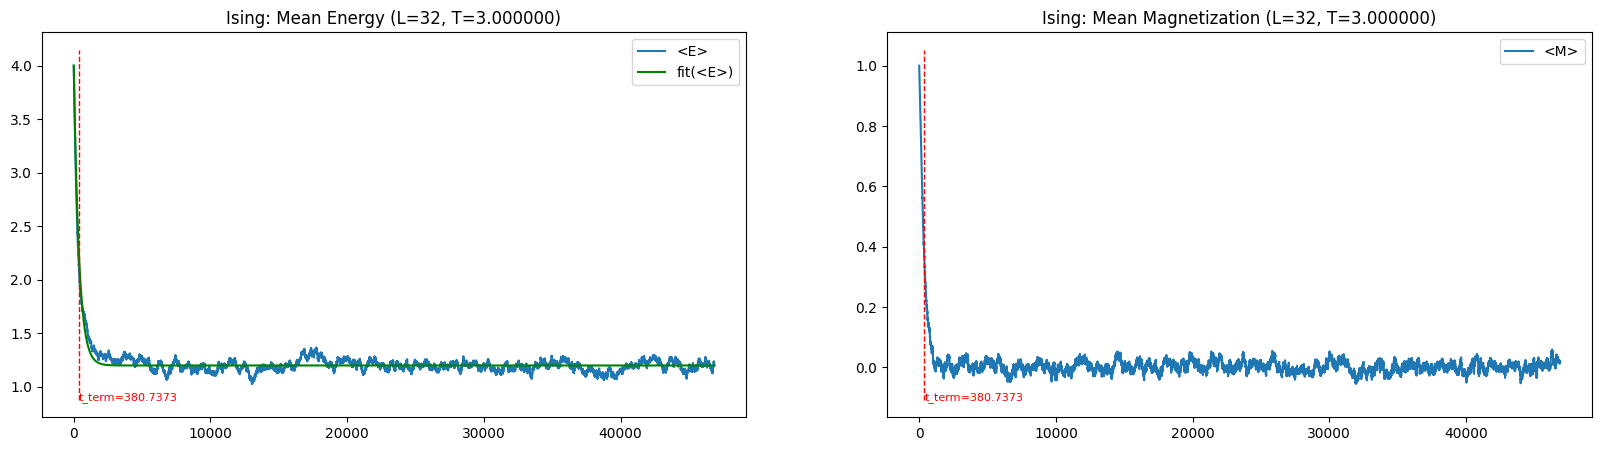

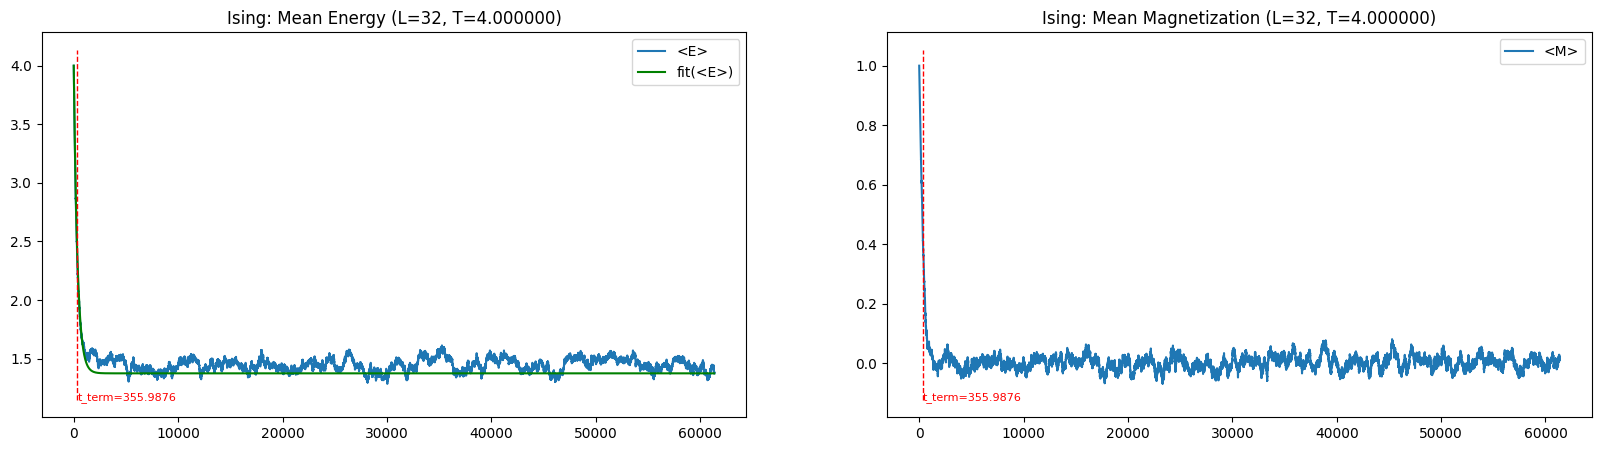

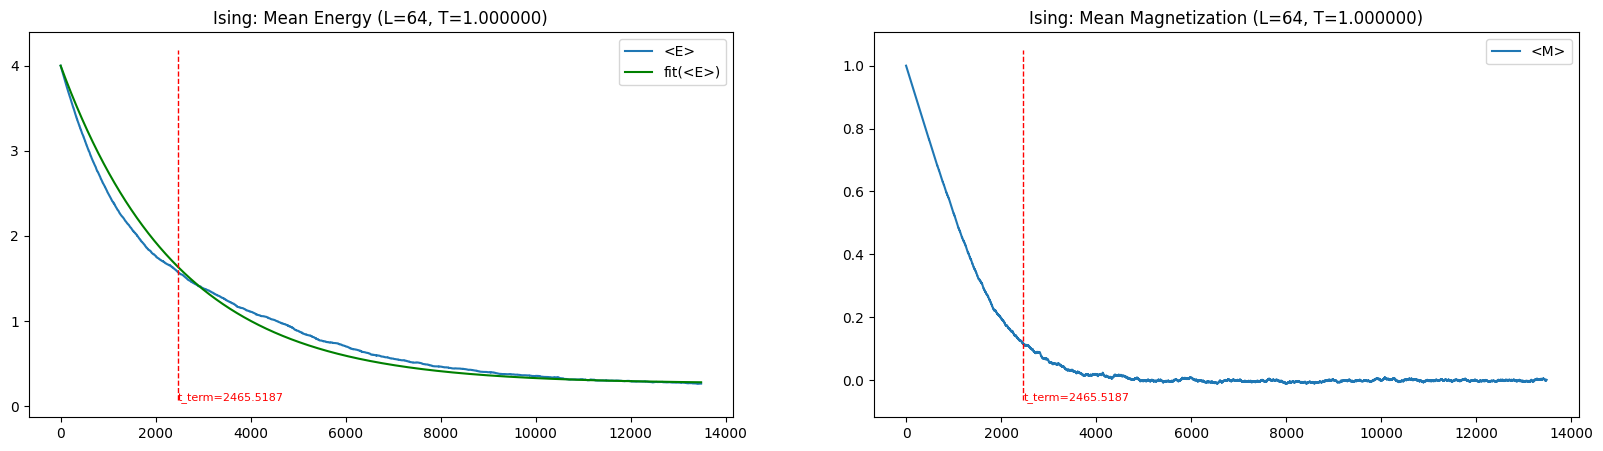

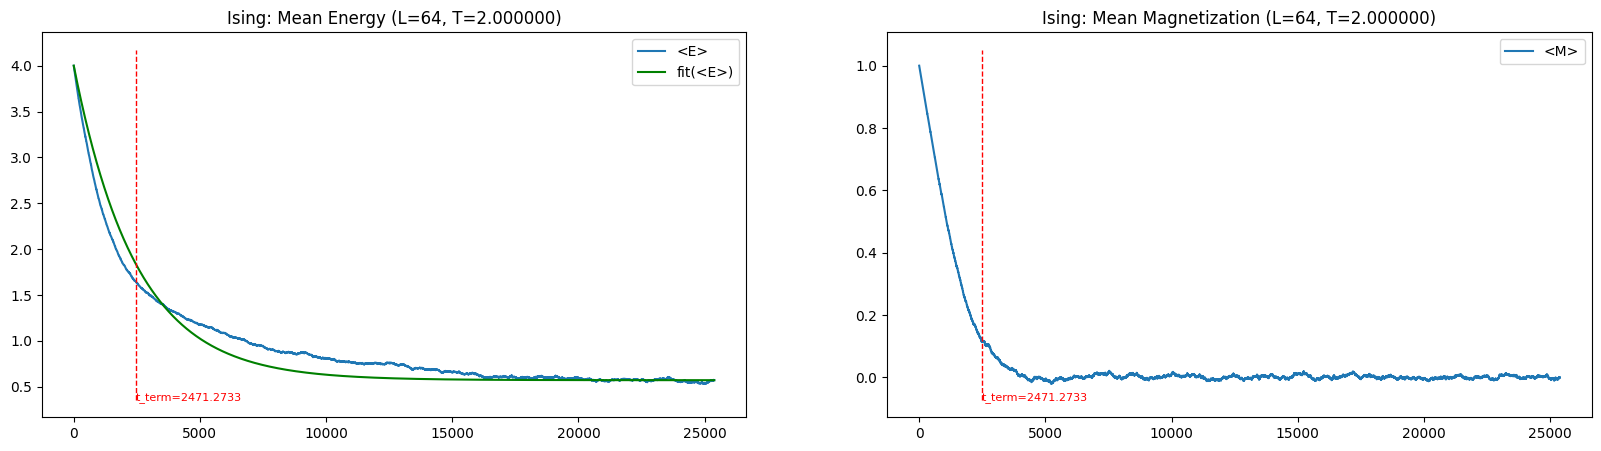

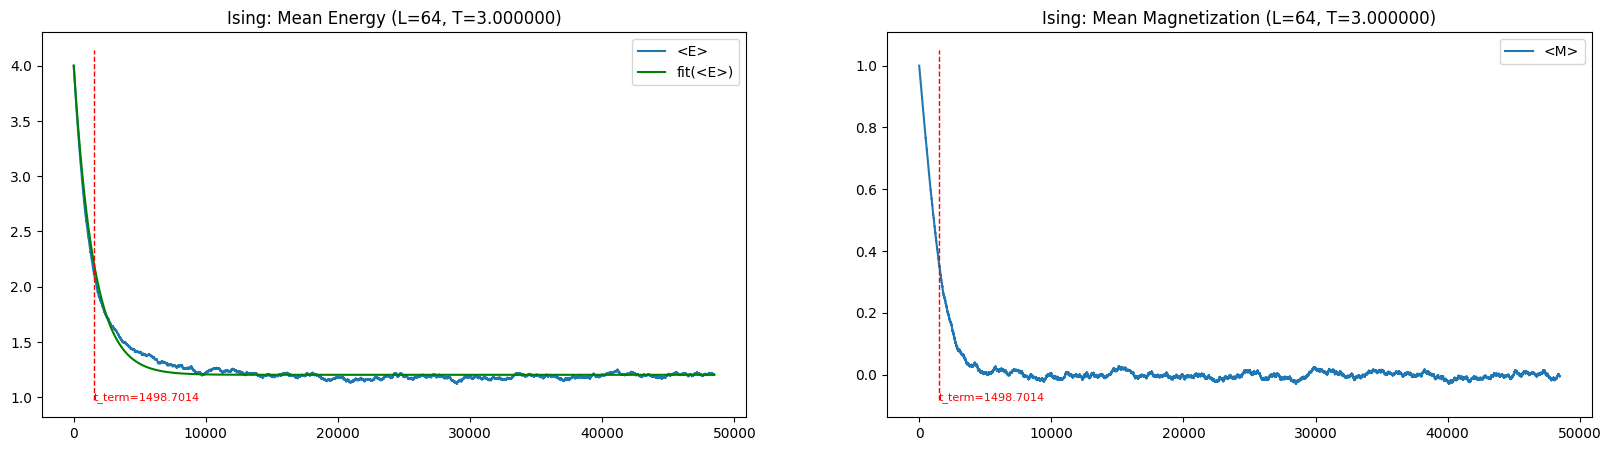

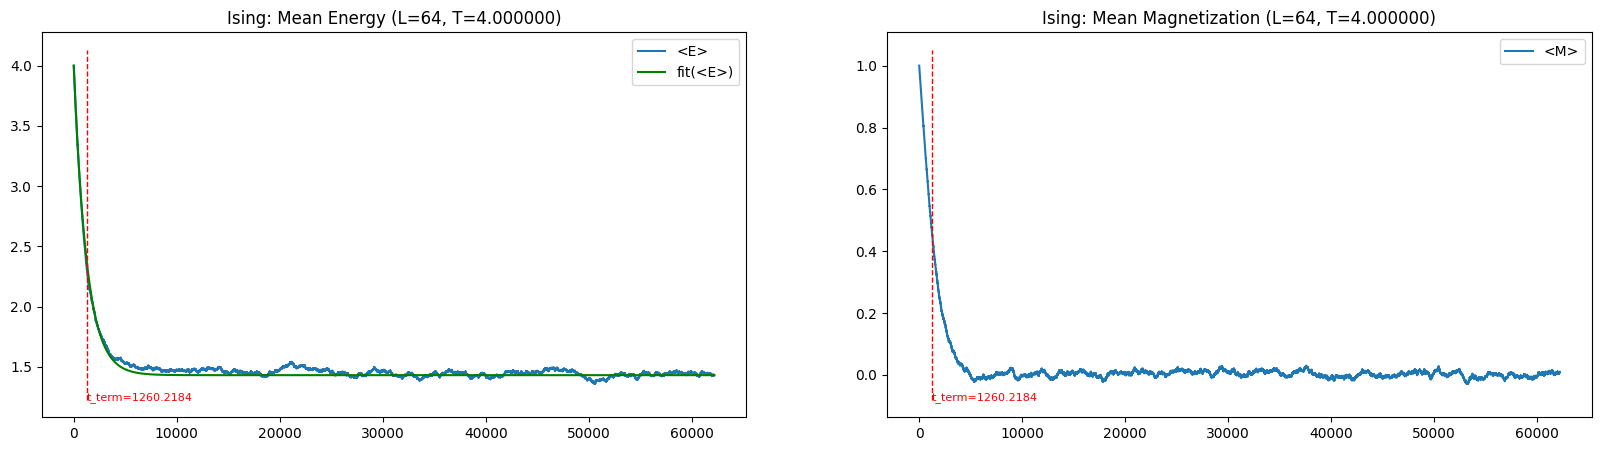

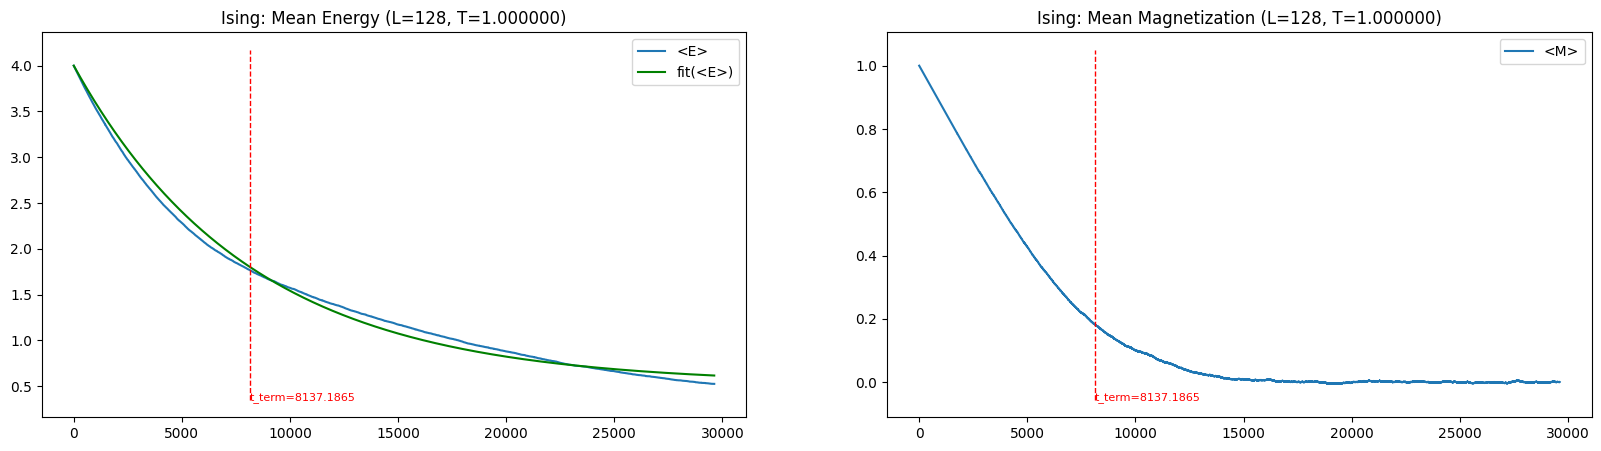

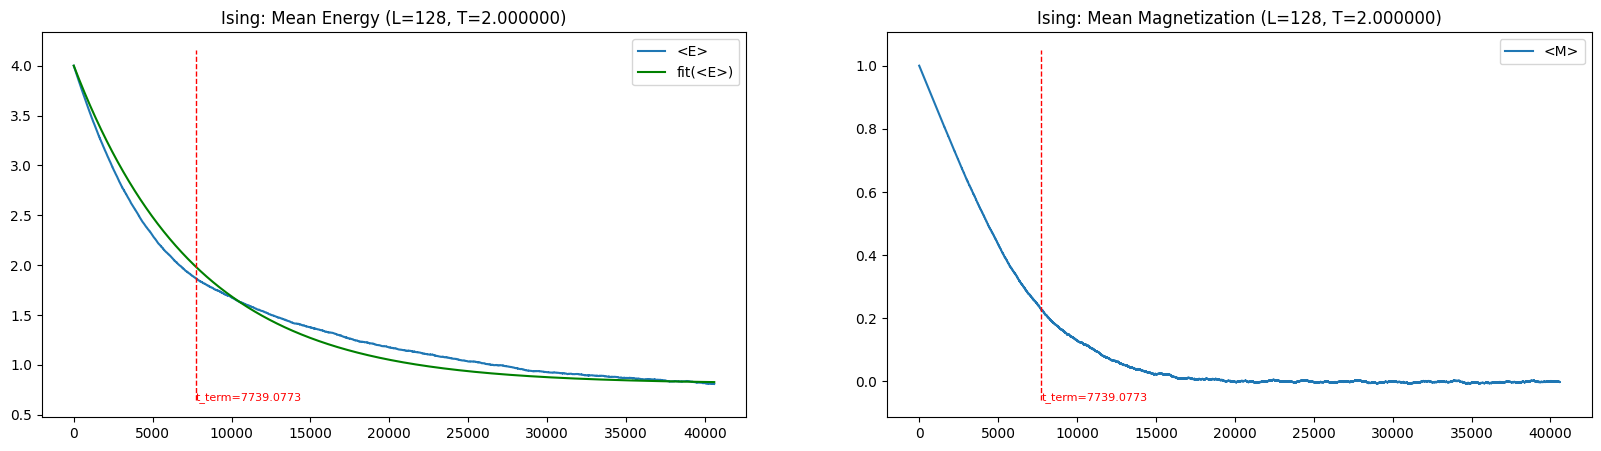

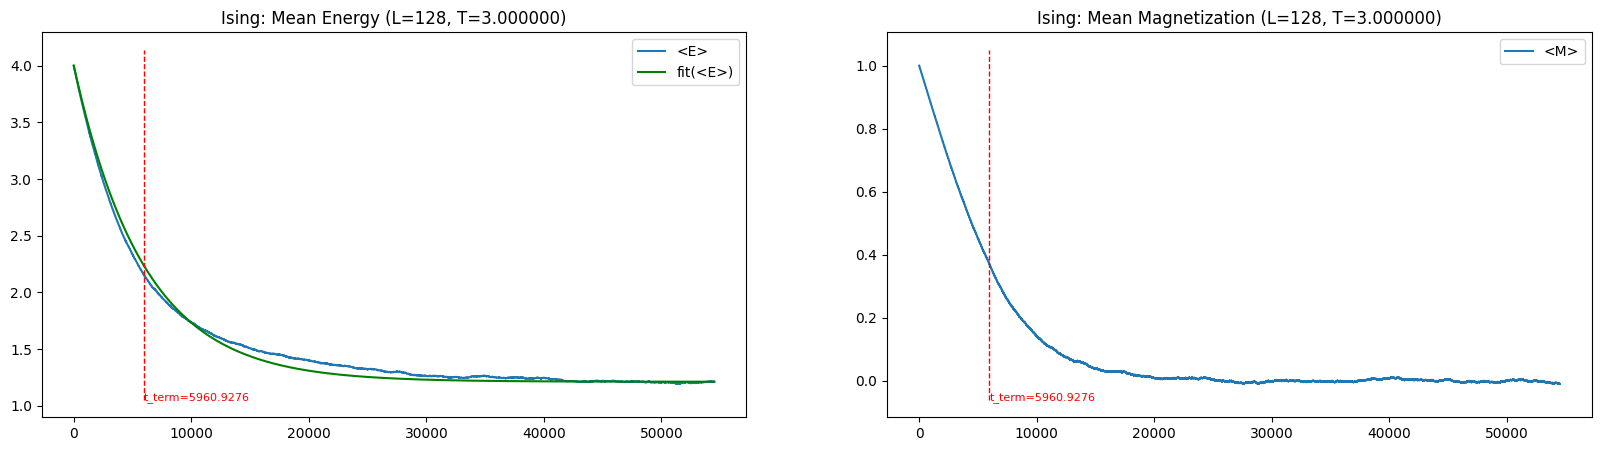

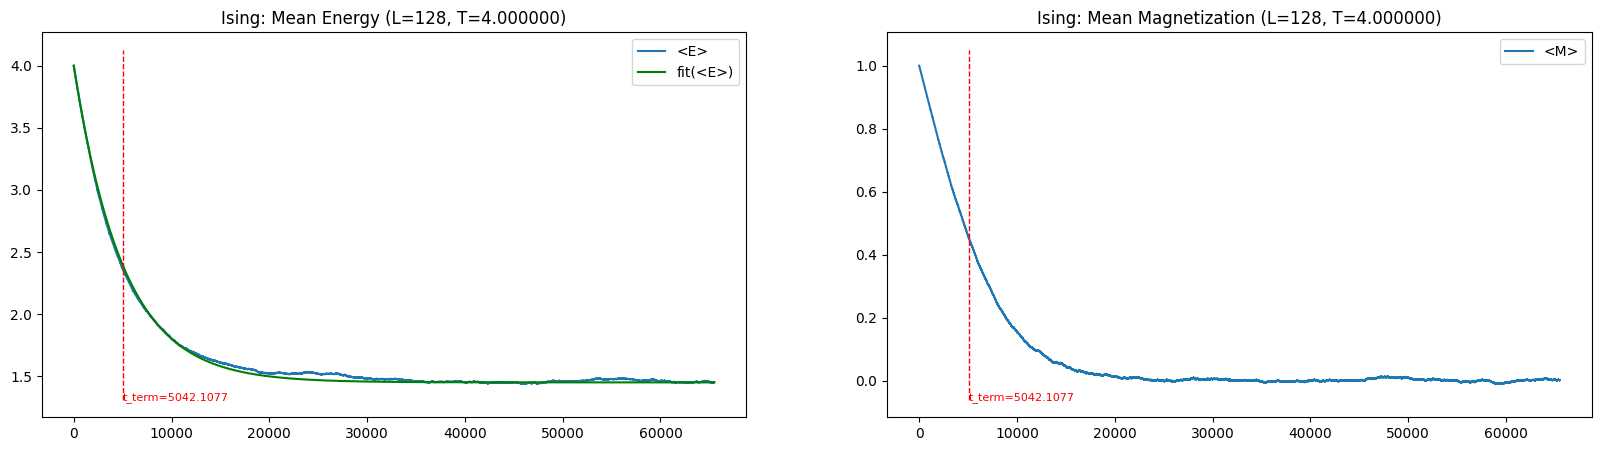

In [130]:
ising_plot_experiments(isings)